In [1]:
from Continuous_Language.Environments.Collectors.collectors import Collectors
from Continuous_Language.Reinforcement_Learning.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from Continuous_Language.Reinforcement_Learning.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
def make_env(sequence_length=0):
    vocab_size = 4
    max_episode_steps = 2048
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_episode_steps, timestep_countdown=15)
    print(sequence_length)
    # env = ParallelFrameStack(env, 4)
    return env

In [3]:
def load(path="models/checkpoints", sequence_length=2):
    env = make_env(sequence_length)
    models = {}
    for model in os.listdir(path):
        if f"collect_seq_{sequence_length}" in model:
            try:
                state_dict = torch.load(os.path.join(path, model))
                timestamp = model.split("_")[-1]
                timestamp = int(timestamp.split(".")[0])
                agent = PPO_Multi_Agent_Centralized(env, device="cpu")
                agent.agent.load_state_dict(state_dict)
                models[timestamp] = agent
            except:
                pass
    return models

In [4]:
num_steps = 10000
models = {}
for i in [1, 2, 3, 4]:
    agents = load("models/checkpoints_collectors_2/models/checkpoints", sequence_length=i)
    models[i] = agents
agent_indizes = list(agents.keys())
agent_indizes.sort()

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1
2
3
4


In [5]:
def perturbation(inputs, model, vocab_size, sequence_length):
    
    # Extract environment inputs
    environment_inputs = inputs[:, :-1 * vocab_size * sequence_length]

    # Extract original logits
    inputs = torch.tensor(inputs, dtype=torch.float32)
    original_logits = model(inputs)
    original_logits = F.softmax(original_logits, dim=1).detach().numpy()
    original_logits = F.log_softmax(torch.tensor(original_logits), dim=1).detach()

    perturbation_logits = []
    for token in range(vocab_size):
        # One-hot encoded sequence of tokens
        utterances = np.array([token for _ in range(sequence_length)])
        utterances = np.eye(vocab_size)[utterances].flatten()
        utterances = np.expand_dims(utterances, axis=0)
        utterances = np.repeat(utterances, inputs.shape[0], axis=0)

        # Concatenate environment inputs with utterances
        perturbation_inputs = np.concatenate((environment_inputs, utterances), axis=1)
        perturbation_inputs = torch.tensor(perturbation_inputs, dtype=torch.float32)

        # Get logits for perturbed inputs
        current_logits = model(perturbation_inputs).detach().numpy()
        current_logits = F.softmax(torch.tensor(current_logits), dim=1).detach().numpy()

        perturbation_logits.append(current_logits)

    divergences = []
    for input_array in perturbation_logits:
        kl_divergences = []
        for i in range(len(input_array)):
            q = F.softmax(torch.tensor(input_array[i]), dim=0)
            kl_div = F.kl_div(original_logits, q, reduction='batchmean').item()
            kl_divergences.append(kl_div)

        divergences.append(kl_divergences)
    max_divergences = np.max(divergences, axis=0)
    return max_divergences

In [6]:
def test_perturbation_saliency(env, agent, epochs=1, tracking_agent="player_1"):
    language_importances = []
    saliencies = []

    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    data = {"ball_1": [], "ball_2": [], "direction_1":[], "direction_2":[], "paddle_1": [], "paddle_2": [], "distances":[], "utterance paddle_1":[], "utterance paddle_2":[]}

    for i in range(epochs):
        timestep = 0
        while True:
            timestep += 1
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            # data = record_data(env, data)
            
            # integrated_grads = smoothgrad(obs_track, agent.agent.actor, 0, sigma=1.0, steps=30)
            language_perturbation = perturbation(obs, agent.agent.actor, env.vocab_size, env.sequence_length)
            language_importances.append(language_perturbation)

            # If any of language_importances is higher thnan 0.002
            obs_track = torch.tensor(obs, dtype=torch.float32, requires_grad=True)

            logits = agent.agent.actor(obs_track)
            grad_tensor = torch.zeros_like(logits)
            grad_tensor[:, :-1 * env.sequence_length * env.vocab_size] = 1

            logits.backward(grad_tensor)

            saliency = obs_track.grad.data.abs()

            saliency = saliency.numpy()
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

            average_language = np.sum(saliency[:, -1 * env.sequence_length * env.vocab_size:], axis=1)
            saliencies.append(average_language)

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return np.array(language_importances), np.array(saliencies)

In [7]:
def get_means(env, model, epochs):
    means = []
    tokens = {channel: {0: 0, 1: 1, 2: 2} for channel in [1, 2]}
    for i in range(epochs):
        obs, info = env.reset()
        state = env.state()
        while True:
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))
            means.append(obs)
            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                action, _, _, _ = model.agent.get_action_and_value(obs, state)
                action = reverse_flatten_list_with_agent_list(action, agent.agents)[0]
            
            action = {agent: cur_action.numpy() for agent, cur_action in action.items()}
            obs, rewards, terminations, truncations, info = env.step(action)
            state = env.state()
            for channel in [1, 2]:
                for paddle in env.agents:
                    cur_token = int(obs[paddle][-1 * channel])
                    tokens[channel][cur_token] += 1
            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                break
    means = np.stack(means)
    return means, tokens

In [8]:
def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=100):
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    assert baseline.shape == inputs.shape
    
    grads = []

    for i in range(num_steps):
        scaled_input = torch.tensor(baseline + (float(i) / steps) * (inputs - baseline), requires_grad=True)
        # scaled_input.requires_grad = True
        logits = model(scaled_input)
        loss = logits[0, target_label_idx]
        loss.backward()
        grads.append(scaled_input.grad.data.cpu().numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grad = (inputs.detach().cpu().numpy() - baseline.cpu().numpy()) * avg_grads

    return integrated_grad

In [9]:
def test_integrated_gradients(agent, env, means, smaller = True , threshold = 0.5, noise=False, epochs=1, tracking_agent="player_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    average_length = []
    average_noise_share = []
    tokens = []
    for i in range(epochs):
        print(f"Epoch {i} out of {epochs}")
        timestep = 0
        noises = []
        while True:
            timestep += 1
            traking_index = env.agents.index(tracking_agent)
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [env.state()]

            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
            
            baselines = torch.tensor(np.expand_dims(means, axis=0), dtype=torch.float32)
            baselines[0] = 9.0
            integrated_grads = integrated_gradients(obs_track, agent.agent.actor, 0, baseline=baselines, steps=10)

            integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())
            language_saliences = np.sum(integrated_grads[0, -1 * env.sequence_length:])

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            saliencies.append(language_saliences)
            full_saliences.append(integrated_grads)

            obs, _, truncations, terminations, infos = env.step(actions)

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
        average_noise_share.append(np.mean(noises))
    full_saliences = np.stack(full_saliences, axis=0)
    saliencies = np.array(saliencies)
    return saliencies, average_length

In [10]:
def test(agent, env, timesteps=1024, tracking_agent="player_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    for timestep in range(timesteps):
            
        traking_index = env.agents.index(tracking_agent)
        tokens.append(obs[tracking_agent][-1 * env.sequence_length * env.vocab_size:])
        obs = [obs]
        state = [state]
        obs = np.array(flatten_list(obs))
        state = np.array(flatten_list(state))

        obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
        logits = agent.agent.actor(obs_track)

        agent.agent.actor.zero_grad()

        grad_tensor = torch.zeros_like(logits)
        grad_tensor[:, :-1 * env.sequence_length * env.vocab_size] = 1

        logits.backward(grad_tensor)

        saliency = obs_track.grad.data.abs()

        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

        importances = []
        
        importances = np.max(saliency[:, -1 * env.sequence_length * env.vocab_size:], axis=1)

        obs = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
            actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

        actions = actions[0]
        actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

        saliencies.append(importances)
        full_saliences.append(saliency)

        obs, _, truncations, terminations, infos = env.step(actions)
        state = env.state()

        if any([truncations[agent] or terminations[agent] for agent in env.agents]):
            average_length.append(timestep)
            obs, info = env.reset()
    full_saliences = np.stack(full_saliences, axis=0)
    saliencies = np.array(saliencies)
    return saliencies, average_length, full_saliences, np.array(tokens)

In [11]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(25, 5))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    rect = plt.Rectangle((-0.1, 9.5), data_reshaped.shape[0] - 0.9, 1.99, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

2
{1: {5130: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33651d390>, 6650: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x107c64790>, 10260: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727a650>, 8550: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727bb20>, 1140: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727a830>, 950: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727b250>, 2660: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727ad40>, 9310: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x33727a9b0>, 7030: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centralized object at 0x107cdb1c0>, 4750: <ThesisPackage.RL.Centralized_PPO.multi_ppo.PPO_Multi_Agent_Centraliz

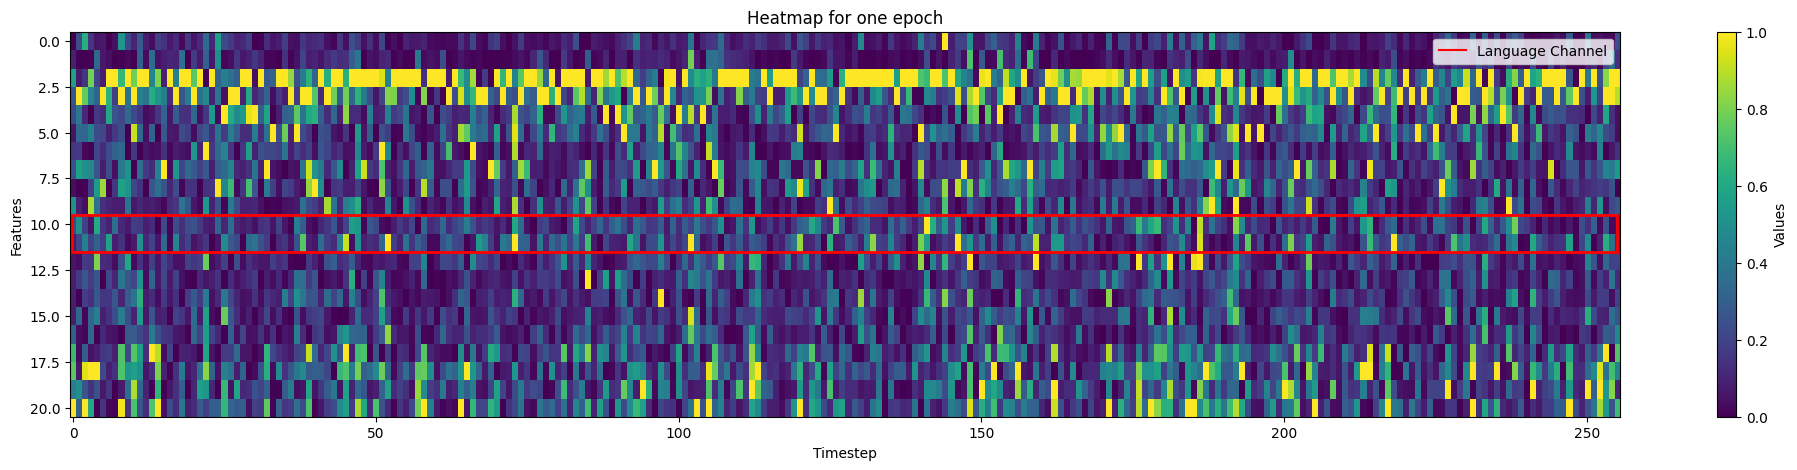

In [12]:
env = make_env(2)
print(models)
saliencies, average_length, full_saliences, tokens = test(models[2][agent_indizes[-1]], env, timesteps=256)
plot_saliencies(full_saliences)

In [ ]:
model = models[2]
env = make_env(2)
model = dict(sorted(model.items()))

for index, agent in tqdm(model.items()):
    saliencies, average_length = test_perturbation_saliency(env, agent, epochs=100)
    print(index, np.where(saliencies > 0.04)[0].sum())

In [13]:
results = {}
def calculate_tracking_saliencies(cur_agents, env):
    number_of_important_saliencies = {}

    for index, agent in tqdm(cur_agents.items(), desc="Processing agents"):
        saliencies, average_length, full_saliences, tokens = test(agent, env, timesteps=10000)
        # print(saliencies)
        number_of_important_saliencies[index] = np.where(saliencies > 0.8)[0].sum()

    return number_of_important_saliencies

for seq, cur_agents in models.items():
    env = make_env(seq)
    results[seq] = calculate_tracking_saliencies(cur_agents, env)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1


Processing agents:   0%|          | 0/60 [00:00<?, ?it/s]/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_13163/367598545.py:30: RuntimeWarning: invalid value encountered in divide
  saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
Processing agents: 100%|██████████| 60/60 [05:13<00:00,  5.22s/it]


2


Processing agents: 100%|██████████| 60/60 [05:57<00:00,  5.96s/it]


3


Processing agents: 100%|██████████| 60/60 [06:34<00:00,  6.57s/it]


4


Processing agents: 100%|██████████| 60/60 [07:24<00:00,  7.41s/it]


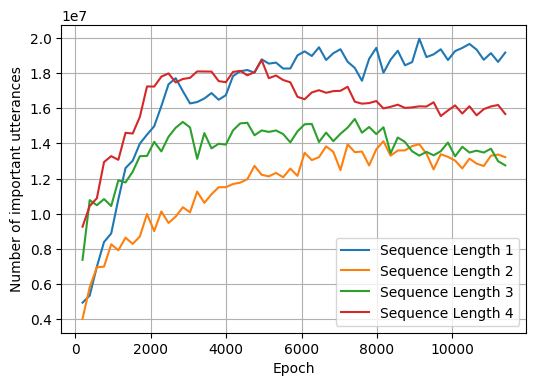

In [14]:
# Sort the dictionary by keys (indices)
# Plotting
plt.figure(figsize=(6, 4))

for seq, number_of_important_saliencies in results.items():
    sorted_data = dict(sorted(number_of_important_saliencies.items()))
    plt.plot(sorted_data.keys(), sorted_data.values(), label=f"Sequence Length {seq}")
plt.xlabel('Epoch')
plt.ylabel('Number of important utterances')
plt.legend()
plt.grid(True)
plt.savefig("saliencies_live/important_utterances_final_collectors.pdf")